In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx


First I need to create an adjacency table from my shape file.

In [2]:
# Step 1: Read the shapefile into a GeoDataFrame
# Replace 'your_shapefile.shp' with the actual path to your shapefile
gdf = gpd.read_file(r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\taxi_zones (2)\taxi_zones.shp")

# Step 2: Create a dictionary to store adjacency relationships
adjacency_dict = {}

# Step 3: Iterate through each geometry and find adjacent areas
for idx, row in gdf.iterrows():
    adjacent_areas_touches = gdf[gdf.geometry.touches(row['geometry'])]['LocationID'].tolist()
    adjacent_areas_overlaps = gdf[gdf.geometry.overlaps(row['geometry'])]['LocationID'].tolist()

    neighbors = np.union1d(adjacent_areas_touches, adjacent_areas_overlaps)
    adjacency_dict[row['LocationID']] = neighbors

# Step 4: Create a table (pandas DataFrame) from the adjacency dictionary
adjacency_table = pd.DataFrame(adjacency_dict.items(), columns=['LocationID', 'Adjacent_LocationIDs'])

# Step 5: Print or manipulate the adjacency table as needed
print(adjacency_table)

     LocationID                Adjacent_LocationIDs
0             1                                  []
1             2                           [30, 132]
2             3    [32, 51, 81, 184, 185, 242, 254]
3             4                 [79, 148, 224, 232]
4             5                 [84.0, 99.0, 204.0]
..          ...                                 ...
255         259                      [81, 240, 254]
256         260         [7, 83, 129, 157, 207, 226]
257         261          [12, 13, 87, 88, 209, 231]
258         262         [75.0, 140.0, 141.0, 263.0]
259         263  [75.0, 140.0, 141.0, 236.0, 262.0]

[260 rows x 2 columns]


In [3]:
adjacency_table
#I checked this code against tableau and it works!

,LocationID,Adjacent_LocationIDs
0,1,[]
1,2,"[30, 132]"
2,3,"[32, 51, 81, 184, 185, 242, 254]"
3,4,"[79, 148, 224, 232]"
4,5,"[84.0, 99.0, 204.0]"
...,...,...
255,259,"[81, 240, 254]"
256,260,"[7, 83, 129, 157, 207, 226]"
257,261,"[12, 13, 87, 88, 209, 231]"
258,262,"[75.0, 140.0, 141.0, 263.0]"


In [4]:
adjacency_table.iloc[1,0]

2

In [5]:
adjacency_table.loc[135,:]


LocationID                                   139
Adjacent_LocationIDs    [38, 203, 205, 218, 219]
Name: 135, dtype: object

In [6]:
adjacency_table

,LocationID,Adjacent_LocationIDs
0,1,[]
1,2,"[30, 132]"
2,3,"[32, 51, 81, 184, 185, 242, 254]"
3,4,"[79, 148, 224, 232]"
4,5,"[84.0, 99.0, 204.0]"
...,...,...
255,259,"[81, 240, 254]"
256,260,"[7, 83, 129, 157, 207, 226]"
257,261,"[12, 13, 87, 88, 209, 231]"
258,262,"[75.0, 140.0, 141.0, 263.0]"


In [7]:
adjacency_table.iloc[257,0]

261

I tested 5 zones in Tableau! No issues! Now I'm going to transform the table to I can merge it with my overall dataset.

In [8]:
locIDs = adjacency_table['Adjacent_LocationIDs']

IDs = []
adjIDs = []

for x in range(len(locIDs)):
    for id in range(len(locIDs[x])):
        IDs.append(adjacency_table.iloc[x,0])
        adjIDs.append(locIDs[x][id])

In [9]:
adjacencytable_transformed = pd.DataFrame(IDs,adjIDs).reset_index()
adjacencytable_transformed.rename(columns={'index': 'LocID'}, inplace=True)

In [10]:
adjacencytable_transformed.rename(columns={0: 'Adjacent_District'}, inplace=True)

In [11]:
adjacencytable_transformed.loc[adjacencytable_transformed['LocID']==128]
#Correct answer: [32, 51, 81, 184, 185, 242, 254]
#appears to work

,LocID,Adjacent_District
618,128.0,127
1070,128.0,220
1195,128.0,243


Manually adding bridges and tunnels!

In [12]:
Data = {'LocID':[255,4,145,233,140,202,202,193,8,194,194,74,194,168,252,208,15,208,6,14,54,12,33,209,66,232,27,154,201,124,86,132], 'Adjacent_District':[4,255,233,145,202,140,193,202,194,8,74,194,168,194,208,252,208,15,14,6,12,54,209,33,232,66,154,27,124,201,132,86]}
Bridges_and_tunnels = pd.DataFrame(Data)
adjacencytable_transformed = pd.concat([adjacencytable_transformed, Bridges_and_tunnels], ignore_index=True)

Now, I will merge with a csv of 2022 trips: Pickup Location, Dropoff Location, and number of trips overall.

In [13]:
df2022 = pd.read_csv(r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\rideshares2022DOLocationIDxPULocationID.csv")

In [14]:
merged_df = pd.merge(df2022, adjacencytable_transformed, left_on=['PULocationID','DOLocationID'], right_on=['LocID', 'Adjacent_District'])
merged_df

,DOLocationID,PULocationID,trips,LocID,Adjacent_District
0,2,30,7,30.0,2
1,2,132,18,132.0,2
2,3,32,23000,32.0,3
3,3,51,30175,51.0,3
4,3,81,24298,81.0,3
...,...,...,...,...,...
1314,263,75,38693,75.0,263
1315,263,140,33708,140.0,263
1316,263,141,36169,141.0,263
1317,263,236,32364,236.0,263


In [15]:
merged_df = merged_df.drop(['LocID','Adjacent_District'], axis =1)

In [16]:
merged_df.loc[merged_df['PULocationID']==260]
#[7, 83, 129, 157, 207, 226] -- just checking to make sure the right districts were filtered.
#It works!

,DOLocationID,PULocationID,trips
28,7,260,72538
413,83,260,38705
643,129,260,68886
779,157,260,38000
1032,207,260,5248
1127,226,260,65752


Turning my merged 2022 data frame into a graph

In [17]:
G = nx.DiGraph()
for _, row in merged_df.iterrows():
    G.add_edge(row['PULocationID'], row['DOLocationID'], weight=row['trips'])
#want to retry this while maximizing for dollars spent

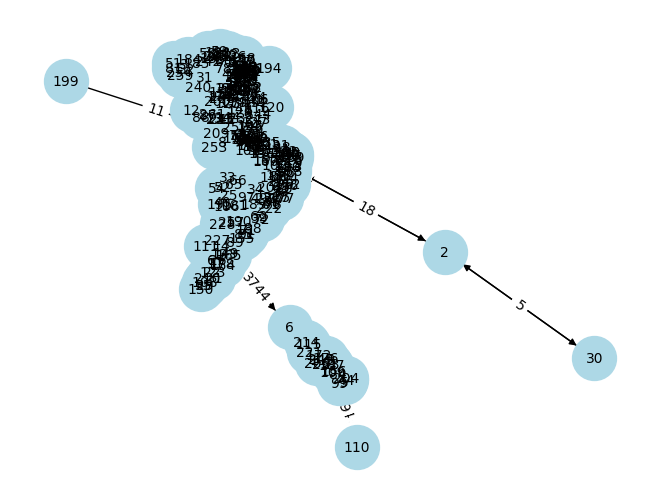

In [18]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)  # positions for all nodes

nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_color='black')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()


In [29]:
paths = []
weights = []

for path in nx.all_simple_paths(G, source=223, target=179, cutoff = 11):
    new_weight = nx.path_weight(G, path, weight = 'weight')
    paths.append(path)
    weights.append(new_weight)


In [30]:
paths_DF = pd.DataFrame({'paths':paths, 'Weights':weights})

In [31]:
paths_DF

,paths,Weights
0,"[223, 7, 146, 145, 193, 179]",297901
1,"[223, 7, 146, 145, 233, 162, 141, 140, 202, 19...",394908
2,"[223, 7, 146, 145, 233, 162, 141, 229, 140, 20...",431677
3,"[223, 7, 146, 145, 233, 162, 141, 262, 140, 20...",417028
4,"[223, 7, 146, 145, 233, 162, 141, 263, 140, 20...",436811
...,...,...
11895,"[223, 207, 260, 226, 146, 145, 193, 7, 179]",321894
11896,"[223, 207, 260, 226, 146, 145, 193, 179]",185148
11897,"[223, 207, 260, 226, 146, 145, 233, 229, 140, ...",240040
11898,"[223, 207, 260, 226, 146, 193, 7, 179]",268506


In [32]:
result_list = []
path_combo_list = []

for path in paths_DF['paths']:
    path_combinations = []
    for i in range(len(path)):
        for j in range(i + 1, len(path)):
            path_combinations.append((path[i],path[j]))
    result_list.append(path_combinations)

# Print the result_list or perform further processing
for path_combinations in result_list:
    path_combo_list.append(path_combinations)


In [33]:
#this needs to be on the original dataframe
result_dict = {}

for loc, adj_loc, dist in zip(df2022['DOLocationID'], df2022['PULocationID'], df2022['trips']):
    key = (loc, adj_loc)  # Combine loc and adj_loc into a tuple
    result_dict[key] = dist

result_dict

{(1, 1): 21,
 (1, 2): 1,
 (1, 3): 232,
 (1, 4): 5728,
 (1, 5): 1511,
 (1, 6): 1234,
 (1, 7): 2589,
 (1, 8): 8,
 (1, 9): 132,
 (1, 10): 572,
 (1, 11): 489,
 (1, 12): 191,
 (1, 13): 19862,
 (1, 14): 4238,
 (1, 15): 133,
 (1, 16): 216,
 (1, 17): 5354,
 (1, 18): 420,
 (1, 19): 81,
 (1, 20): 715,
 (1, 21): 736,
 (1, 22): 1121,
 (1, 23): 5703,
 (1, 24): 3138,
 (1, 25): 9712,
 (1, 26): 2667,
 (1, 27): 20,
 (1, 28): 294,
 (1, 29): 555,
 (1, 30): 4,
 (1, 31): 43,
 (1, 32): 240,
 (1, 33): 8855,
 (1, 34): 400,
 (1, 35): 342,
 (1, 36): 3040,
 (1, 37): 5580,
 (1, 38): 127,
 (1, 39): 438,
 (1, 40): 4201,
 (1, 41): 5619,
 (1, 42): 4255,
 (1, 43): 2912,
 (1, 44): 1358,
 (1, 45): 4391,
 (1, 46): 63,
 (1, 47): 265,
 (1, 48): 49810,
 (1, 49): 6359,
 (1, 50): 19804,
 (1, 51): 253,
 (1, 52): 2586,
 (1, 53): 151,
 (1, 54): 897,
 (1, 55): 647,
 (1, 56): 224,
 (1, 57): 38,
 (1, 58): 96,
 (1, 59): 8,
 (1, 60): 160,
 (1, 61): 6796,
 (1, 62): 1922,
 (1, 63): 201,
 (1, 64): 111,
 (1, 65): 8033,
 (1, 66): 4581,
 (

In [34]:
sums = []
for l in range(len(path_combo_list)):
    list1 = []
    for val in range(len(path_combo_list[l])):
        try:
            list1.append(result_dict[path_combo_list[l][val]])
        except KeyError:
            list1.append(0)  # Append 0 in case of key error
    sumnums = sum(list1)
    sums.append(sumnums)


In [35]:
pathdf = pd.DataFrame({'paths':paths, 'Weights':weights, 'path_combo_list': path_combo_list, 'sums': sums})

In [36]:
pathdf['total_weight'] = pathdf['Weights'] +pathdf['sums']

In [37]:
top  = pathdf.sort_values('sums', ascending=False).head(5)
weights_column = top['paths']
toplist = weights_column.tolist()
top

,paths,Weights,path_combo_list,sums,total_weight
10391,"[223, 138, 129, 260, 83, 82, 157, 226, 145, 14...",618509,"[(223, 138), (223, 129), (223, 260), (223, 83)...",2456871,3075380
9470,"[223, 138, 129, 82, 83, 260, 157, 226, 145, 14...",657917,"[(223, 138), (223, 129), (223, 82), (223, 83),...",2455657,3113574
9449,"[223, 138, 129, 82, 83, 157, 260, 226, 145, 14...",672392,"[(223, 138), (223, 129), (223, 82), (223, 83),...",2454379,3126771
9514,"[223, 138, 129, 82, 157, 83, 260, 226, 145, 14...",661088,"[(223, 138), (223, 129), (223, 82), (223, 157)...",2454360,3115448
9807,"[223, 138, 129, 83, 82, 157, 260, 226, 145, 14...",615491,"[(223, 138), (223, 129), (223, 83), (223, 82),...",2451169,3066660


Double check, but I think sums is the correct number. Total_Weight double adds the adjacent weights while sums already includes them.

In [38]:
for x in range(len(toplist[0])):
    print(toplist[0][x])

223
138
129
260
83
82
157
226
145
146
7
179
